# Setting the environment and imports

In [1]:
from IPython.display import clear_output

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install smp
!pip install segmentation-models-pytorch
clear_output()

In [4]:
# Clone to the github repository
!git clone https://github.com/qubvel/segmentation_models.pytorch.git
clear_output()

In [5]:
# Imports
import os
import shutil
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import torch
import albumentations as albu
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

try:
    os.rename('/content/segmentation_models.pytorch', '/content/segmentation_models__pytorch')
except FileNotFoundError:
    print('Already renamed!')


# Data Processing

In [6]:
# Unzipping the dataset
!unzip /content/drive/MyDrive/2024ImageSegmentation/CRACK500.zip
clear_output()

In [7]:
# Removing the irrelevant files, structuring the folders, and counting
source_paths = ['/content/valdata', '/content/testdata', '/content/traindata', '/content/training_set', '/content/test.txt', '/content/train.txt', '/content/val.txt']
destination_path = '/content/sample_data'
for path in source_paths:
    shutil.move(path, destination_path)

os.mkdir('/content/data')
os.mkdir('/content/data/trainimgs')
os.mkdir('/content/data/trainlabels')
os.mkdir('/content/data/valimgs')
os.mkdir('/content/data/vallabels')
os.mkdir('/content/data/testimgs')
os.mkdir('/content/data/testlabels')
traincrop_path = '/content/traincrop'
testcrop_path = '/content/testcrop'
valcrop_path = '/content/valcrop'
traincrop_files = os.listdir(traincrop_path)
testcrop_files = os.listdir(testcrop_path)
valcrop_files = os.listdir(valcrop_path)

for img in traincrop_files:
    if img[-3:] == 'jpg':
        shutil.move('/content/traincrop/'+img , '/content/data/trainimgs')
    else:
        shutil.move('/content/traincrop/'+img , '/content/data/trainlabels')
for img in valcrop_files:
    if img[-3:] == 'jpg':
        shutil.move('/content/valcrop/'+img , '/content/data/valimgs')
    else:
        shutil.move('/content/valcrop/'+img , '/content/data/vallabels')
for img in testcrop_files:
    if img[-3:] == 'jpg':
        shutil.move('/content/testcrop/'+img , '/content/data/testimgs')
    else:
        shutil.move('/content/testcrop/'+img , '/content/data/testlabels')

shutil.rmtree('/content/traincrop')
shutil.rmtree('/content/valcrop')
shutil.rmtree('/content/testcrop')

trainimgs_path = '/content/data/trainimgs'
testimgs_path = '/content/data/testimgs'
valimgs_path = '/content/data/valimgs'
trainimgs_files = os.listdir(trainimgs_path)
testimgs_files = os.listdir(testimgs_path)
valimgs_files = os.listdir(valimgs_path)
trainlabels_path = '/content/data/trainlabels'
testlabels_path = '/content/data/testlabels'
vallabels_path = '/content/data/vallabels'
trainlabels_files = os.listdir(trainlabels_path)
testlabels_files = os.listdir(testlabels_path)
vallabels_files = os.listdir(vallabels_path)
print("Number of train images: ", len(trainimgs_files))
print("Number of test images: ", len(testimgs_files))
print("Number of val images: ", len(valimgs_files))

Number of train images:  1896
Number of test images:  1124
Number of val images:  348


In [8]:
# Resize the images from (360, 640, 3) to (288, 512, 3) in order to make them divisible by 32, and modifying the masks for binary segmentation
for img in trainimgs_files:
    original_image = cv2.imread(trainimgs_path + '/' + img)
    resized_image = cv2.resize(original_image, (512, 288), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(trainimgs_path + '/' + img, resized_image)
for img in testimgs_files:
    original_image = cv2.imread(testimgs_path + '/' + img)
    resized_image = cv2.resize(original_image, (512, 288), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(testimgs_path + '/' + img, resized_image)
for img in valimgs_files:
    original_image = cv2.imread(valimgs_path + '/' + img)
    resized_image = cv2.resize(original_image, (512, 288), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(valimgs_path + '/' + img, resized_image)

for img in trainlabels_files:
    original_image = cv2.imread(trainlabels_path + '/' + img)
    resized_image = cv2.resize(original_image, (512, 288), interpolation=cv2.INTER_NEAREST)
    resized_image[resized_image == 255] = 1
    cv2.imwrite(trainlabels_path + '/' + img[:-3] + 'jpg', resized_image)
    os.remove(trainlabels_path + '/' + img)
for img in testlabels_files:
    original_image = cv2.imread(testlabels_path + '/' + img)
    resized_image = cv2.resize(original_image, (512, 288), interpolation=cv2.INTER_NEAREST)
    resized_image[resized_image == 255] = 1
    cv2.imwrite(testlabels_path + '/' + img[:-3] + 'jpg', resized_image)
    os.remove(testlabels_path + '/' + img)
for img in vallabels_files:
    original_image = cv2.imread(vallabels_path + '/' + img)
    resized_image = cv2.resize(original_image, (512, 288), interpolation=cv2.INTER_NEAREST)
    resized_image[resized_image == 255] = 1
    cv2.imwrite(vallabels_path + '/' + img[:-3] + 'jpg', resized_image)
    os.remove(vallabels_path + '/' + img)

trainlabels_files = os.listdir(trainlabels_path)
testlabels_files = os.listdir(testlabels_path)
vallabels_files = os.listdir(vallabels_path)

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# Dataloader

In [10]:
# Dataset class
class Dataset(BaseDataset):

    CLASSES = ['asphalt', 'cracks']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cracks)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [11]:
# Testing the Dataset class
dataset = Dataset(trainimgs_path, trainlabels_path, classes=['cracks'])
image, mask = dataset[193]
# visualize(
#     image=image,
#     cracks_mask=mask.squeeze(),
# )

In [12]:
# Albumentations augmentation
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.RandomCrop(height=256, width=480, always_apply=True),


        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        # albu.PadIfNeeded(384, 480)
        albu.PadIfNeeded(288, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [13]:
# Testing augmentation
augmented_dataset = Dataset(
    trainimgs_path,
    trainlabels_path,
    augmentation=get_training_augmentation(),
    classes=['cracks'],
)
clear_output()
# # same image with different random transforms
# for i in range(3):
#     image, mask = augmented_dataset[9]
#     visualize(image=image, mask=mask.squeeze(-1))

# Creating the model

In [14]:
# Selecting model and encoder
ENCODER = 'mit_b5'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['cracks']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'


model = smp.MAnet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b5.pth" to /root/.cache/torch/hub/checkpoints/mit_b5.pth
100%|██████████| 313M/313M [00:01<00:00, 238MB/s]


In [15]:
# Creating train and validation datasets
train_dataset = Dataset(
    trainimgs_path,
    trainlabels_path,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    valimgs_path,
    vallabels_path,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

# Configue batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)

# Configue batch_size = 4
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)


valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

clear_output()

In [16]:
# Implementing dice metric and puting it into the files

functionalpy_path = '/content/segmentation_models__pytorch/segmentation_models_pytorch/utils/functional.py'

dice_content0 = '\n'
dice_content1 = 'def Dice(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):\n'
dice_content2 = '    """Calculate Dice coefficient between ground truth and prediction\n'
dice_content3 = '    Args:\n'
dice_content4 = '        pr (torch.Tensor): predicted tensor\n'
dice_content5 = '        gt (torch.Tensor):  ground truth tensor\n'
dice_content6 = '        eps (float): epsilon to avoid zero division\n'
dice_content7 = '        threshold: threshold for outputs binarization\n'
dice_content8 = '    Returns:\n'
dice_content9 = '        float: Dice coefficient\n'
dice_content10 = '    """\n'
dice_content11 = '    pr = _threshold(pr, threshold=threshold)\n'
dice_content12 = '    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)\n'
dice_content13 = '\n'
dice_content14 = '    intersection = torch.sum(gt * pr)\n'
dice_content15 = '    dice_coeff = (2. * intersection + eps) / (torch.sum(gt) + torch.sum(pr) + eps)\n'
dice_content16 = '    return dice_coeff\n'
dice_content17 = '\n'
dice_contents = [dice_content17, dice_content16, dice_content15, dice_content14, dice_content13, dice_content12, dice_content11, dice_content10, dice_content9, dice_content8, dice_content7, dice_content6, dice_content5, dice_content4, dice_content3, dice_content2, dice_content1, dice_content0]

with open(functionalpy_path, 'r') as file:
    content = file.readlines()
    for i in range(len(dice_contents)):
        content.insert(40, dice_contents[i])

with open(functionalpy_path, 'w') as file:
    file.writelines(content)


metricspy_path = '/content/segmentation_models__pytorch/segmentation_models_pytorch/utils/metrics.py'

dice_class0 = '\n'
dice_class1 = 'class Dice(base.Metric):\n'
dice_class2 = '    __name__ = "Dice"\n'
dice_class3 = '\n'
dice_class4 = '    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):\n'
dice_class5 = '        super().__init__(**kwargs)\n'
dice_class6 = '        self.eps = eps\n'
dice_class7 = '        self.threshold = threshold\n'
dice_class8 = '        self.activation = Activation(activation)\n'
dice_class9 = '        self.ignore_channels = ignore_channels\n'
dice_class10 = '\n'
dice_class11 = '    def forward(self, y_pr, y_gt):\n'
dice_class12 = '        y_pr = self.activation(y_pr)\n'
dice_class13 = '        return F.Dice(\n'
dice_class14 = '            y_pr,\n'
dice_class15 = '            y_gt,\n'
dice_class16 = '            eps=self.eps,\n'
dice_class17 = '            threshold=self.threshold,\n'
dice_class18 = '            ignore_channels=self.ignore_channels,\n'
dice_class19 = '        )    \n'
dice_classes = [dice_class19, dice_class18, dice_class17, dice_class16, dice_class15, dice_class14, dice_class13, dice_class12, dice_class11, dice_class10, dice_class9, dice_class8, dice_class7, dice_class6, dice_class5, dice_class4, dice_class3, dice_class2, dice_class1, dice_class0]

with open(metricspy_path, 'r') as file:
    content = file.readlines()
    for i in range(len(dice_classes)):
        content.insert(25, dice_classes[i])

with open(metricspy_path, 'w') as file:
    file.writelines(content)

In [31]:
#If continue training
model = torch.load('/content/drive/MyDrive/2024ImageSegmentation/AdamDice8_Epoch27_IoU0.6408_Dice.7593.pth')

In [32]:
# Selecting loss, metrics, and optimizer
import segmentation_models__pytorch.segmentation_models_pytorch.utils.metrics as metricss
import segmentation_models__pytorch.segmentation_models_pytorch.utils.losses as lossess
import segmentation_models__pytorch.segmentation_models_pytorch.utils.train as trainn

metrics = [
    metricss.IoU(threshold=0.5),
    metricss.Dice(threshold=0.5)
]

# Configue optimizer Adam
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.00002)])

# Configue optimizer RMSprop
# optimizer = torch.optim.RMSprop([{'params': model.parameters(), 'lr': 0.0001}])



# Configue Loss Dice
loss = lossess.DiceLoss()

# Configue Loss SoftCrossEntropy
# loss = lossess.SoftCrossEntropyLoss(smooth_factor=0.05)

In [33]:
# create epoch runners, a simple loop of iterating over dataloader`s samples
train_epoch = trainn.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = trainn.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

# Training

In [ ]:
# Train for 60 Epochs, save the best model in terms of val dice_loss, reduce the LR by a factor of 0.2 if no loss reduction in 5 consecutive epochs
minLoss = 100
patience = 0


for i in range(1, 61):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if valid_logs['dice_loss'] < minLoss:
        minLoss = valid_logs['dice_loss']
        torch.save(model, './best_model_Epoch' + str(i) + '.pth')
        print('Model saved!')
        patience = 0
    else:
        patience+=1

    if patience == 5:
        optimizer.param_groups[0]['lr'] *= 0.2
        print('Learning rate reduced to: ', str(optimizer.param_groups[0]['lr']))
        patience = 0


Epoch: 1
train:   0%|          | 0/237 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


valid: 100%|██████████| 348/348 [00:28<00:00, 12.10it/s, dice_loss - 0.2371, iou_score - 0.6443, Dice - 0.7635]
Model saved!

Epoch: 2
valid: 100%|██████████| 348/348 [00:27<00:00, 12.56it/s, dice_loss - 0.2381, iou_score - 0.6423, Dice - 0.7624]

Epoch: 3
valid: 100%|██████████| 348/348 [00:27<00:00, 12.64it/s, dice_loss - 0.2416, iou_score - 0.639, Dice - 0.7589]

Epoch: 4
valid: 100%|██████████| 348/348 [00:27<00:00, 12.57it/s, dice_loss - 0.2377, iou_score - 0.645, Dice - 0.7627]

Epoch: 5
valid: 100%|██████████| 348/348 [00:27<00:00, 12.49it/s, dice_loss - 0.2416, iou_score - 0.6404, Dice - 0.7588]

Epoch: 6
valid: 100%|██████████| 348/348 [00:28<00:00, 12.35it/s, dice_loss - 0.2367, iou_score - 0.6459, Dice - 0.7636]
Model saved!

Epoch: 7
valid: 100%|██████████| 348/348 [00:28<00:00, 12.23it/s, dice_loss - 0.2366, iou_score - 0.6463, Dice - 0.7638]
Model saved!

Epoch: 8
valid: 100%|██████████| 348/348 [00:28<00:00, 12.38it/s, dice_loss - 0.2447, iou_score - 0.6374, Dice - 0.755

# Testing the best model

In [21]:
# load best saved checkpoint
best_model = torch.load('/content/drive/MyDrive/2024ImageSegmentation/AdamDice8_Epoch27_IoU0.6408_Dice.7593.pth')

In [22]:
# create test dataset
test_dataset = Dataset(
    testimgs_path,
    testlabels_path,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [23]:
# evaluate model on test set
test_epoch = trainn.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 1124/1124 [01:31<00:00, 12.26it/s, dice_loss - 0.2864, iou_score - 0.5747, Dice - 0.7141]


# Visulalize outputs

In [25]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    testimgs_path, testlabels_path,
    classes=CLASSES,
)

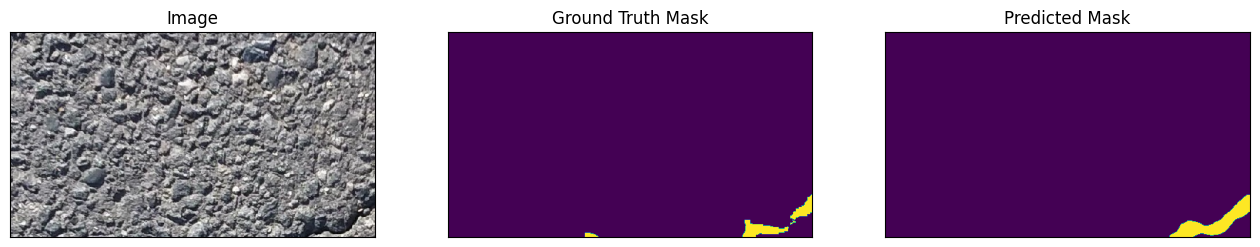

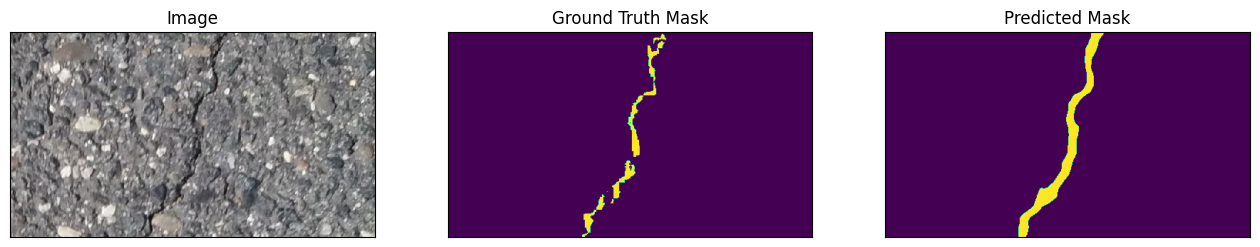

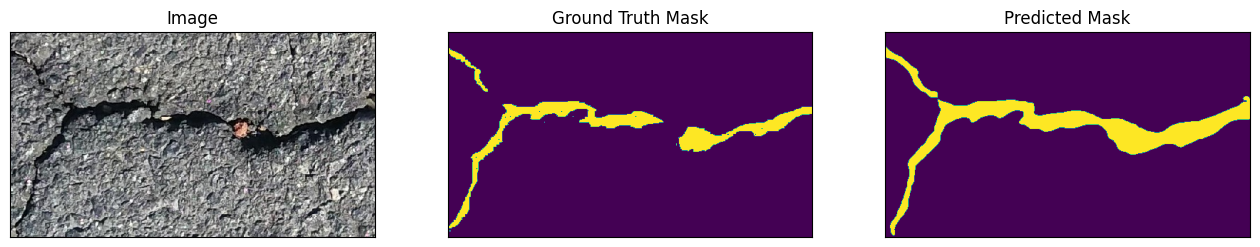

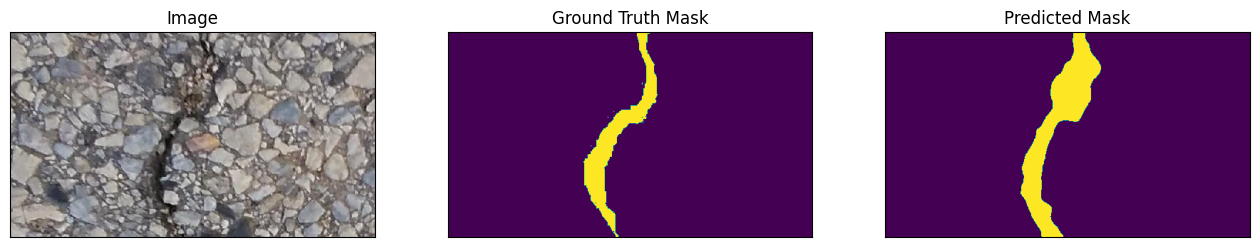

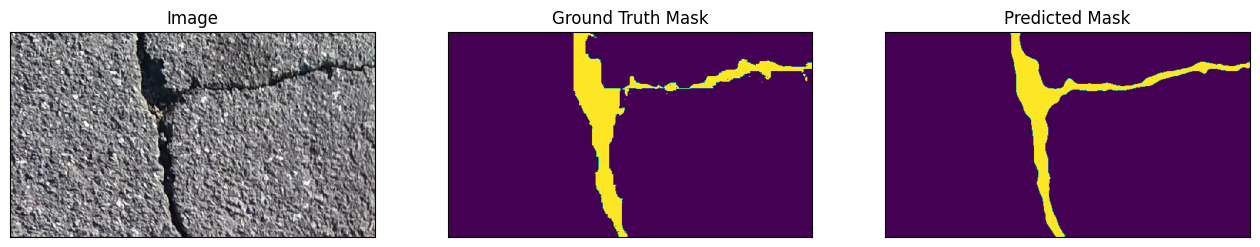

In [26]:
for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )